In [1]:
# Data stuffs
import pickle 
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from scipy import signal
from scipy.stats import norm, truncnorm
import scipy.integrate as integrate
import tqdm.notebook as tqdm 
%matplotlib widget

In [2]:

dataset_choice='SANDBOX_NO_VARIATIONS'
file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle'
with open(file_loc, 'rb') as file:
    massive_dict = pickle.load(file)
full_dict = massive_dict[dataset_choice]
massive_dict = {}

# profiles, mps, masks, psis, rmids, trainids, uncerts
profiles, rmids, ids, uncerts = full_dict['all_dict']['raw']['profiles'], full_dict['all_dict']['raw']['real_space_radii'], full_dict['all_dict']['raw']['pulse_time_ids'], full_dict['all_dict']['raw']['uncerts']

In [3]:
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]

In [320]:
PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == 81768]

,Unnamed: 0,shot,dda,t1,t2,Tepedheight(keV),error_Tepedheight(keV),nepedheight10^19(m^-3),error_nepedheight10^19(m^-3),pepedheight(kPa),...,FLAG:DEUTERIUM,FLAG:HYDROGEN,FLAG:H/Dmix,FLAG:HeJET-C,FLAG:Seeding,FLAG:Kicks,FLAG:RMP,FLAG:pellets,FLAG:HRTSdatavalidated,divertorconfiguration
487,487,81768.0,T001/rfrid,49.1744,51.938599,0.445569,0.009642,5.955019,0.048253,4.199415,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,V/H


In [9]:
plt.close('all')
lor_vals, our_vals, tesep_vals = [], [], []

for idx in range(len(profiles)): 
    ne, te, dne, dte, x = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
    logical_bool_mask = np.logical_and(te < 700, dte < 1000)
    logical_bool_mask = np.logical_and(logical_bool_mask, te > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, te > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, ne > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dte > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dne > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, ne > 2e18)
    ne, te, dne, dte, x = ne[logical_bool_mask], te[logical_bool_mask], dne[logical_bool_mask], dte[logical_bool_mask], x[logical_bool_mask]
    
    name = ids[idx]
    pulse_num, time = name.split('/')

    # relevant_points, estimations = find_nesep(x, te, ne)
    estimations, all_estimations = estimate_nesep(ne, te, dne, dte, x, name)
    tesep, nesep, rsep = estimations
    if tesep > 101: 
        print(all_estimations, tesep, nesep)
    
    # if nesep > 7e19 or nesep < 0.8e19: 
        # ne, te, dne, dte, x = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
        # logical_bool_mask = te < 1000 
        # ne, te, dne, dte, x = ne[logical_bool_mask], te[logical_bool_mask], dne[logical_bool_mask], dte[logical_bool_mask], x[logical_bool_mask]
    #     plot_profiles_and_estimations(ne, te, dne, dte, x, estimations, all_estimations)
    _, lor_val = get_lorenzo_pred(int(pulse_num), time)
    lor_vals.append(1e19*lor_val)
    our_vals.append(nesep)
    tesep_vals.append(tesep)
    

([111.36233996041223, 112.44255798024646, 112.37142683666825, 112.15545387371563, 111.85874422368005, 111.7841223340069, 111.70991570284117, 111.559383307891, 111.48340599935733, 111.4082873905128, 111.10342643232548, 110.94661873057039, 110.78797397631195, 110.70851877426205, 110.21245216708691, 109.94978480392527, 109.77056185863405, 109.30357938134692, 109.10739159556131, 108.80524921497388, 108.48982647293043, 108.48982647293043, 108.48982647293043, 108.28095381381627, 108.28095381381627, 107.8027233041368, 107.5892458283818, 107.5892458283818, 107.03401410213337, 106.55141421501592, 106.42538730765806, 106.42538730765806, 106.42538730765806, 105.87720359372662, 105.62379705198825, 105.49342509238959, 105.49342509238959, 105.49342509238959, 105.49342509238959, 105.36977147680395, 105.11912293426751, 105.11912293426751, 105.11912293426751, 105.11912293426751, 105.00103436683962, 104.63302374186442, 104.37494698227933, 104.37494698227933, 104.1155784087003, 104.1155784087003], [4.618

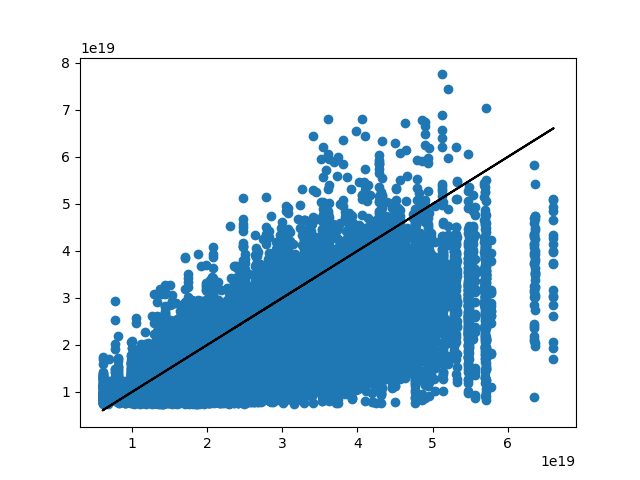

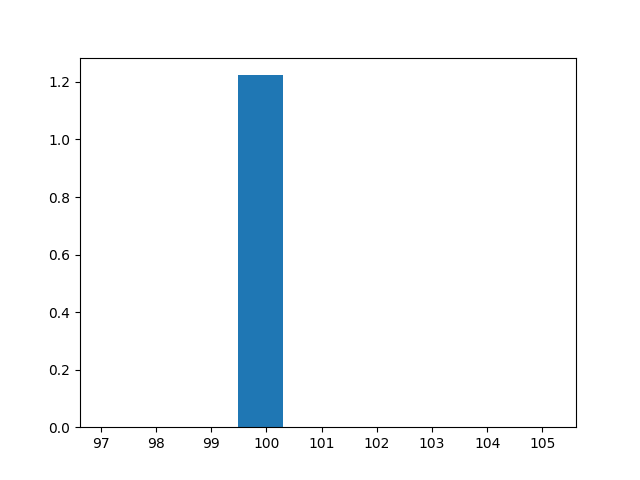

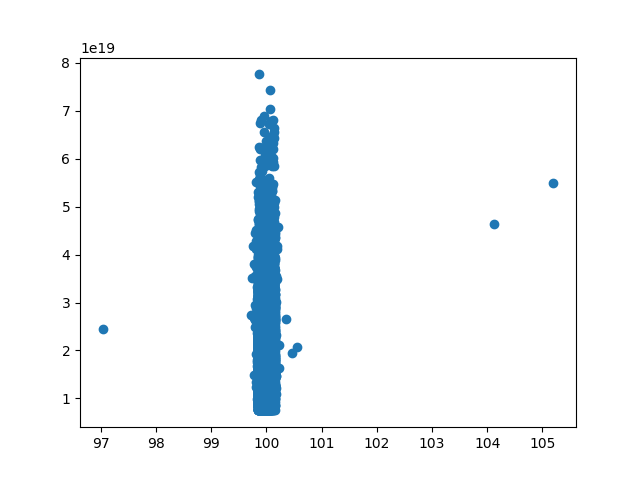

In [10]:
# plt.close('all')
lor_vals, our_vals, tesep_vals = np.array(lor_vals), np.array(our_vals), np.array(tesep_vals)
mask = our_vals > 0.75e19
fig = plt.figure()
plt.scatter(lor_vals[mask], our_vals[mask])
plt.plot(lor_vals, lor_vals, color='black')
plt.show()

fig = plt.figure()
plt.hist(tesep_vals[mask], density=True)# , [100]*len(tesep_vals))
plt.show()

fig = plt.figure()
plt.scatter(tesep_vals[mask], our_vals[mask])
plt.show()

# plt.ylim(0, 1e20)

In [ ]:
print(idx)
# Very large nesep at idx = 16326
idx = 16326
name = ids[idx]
print(name)
ne, te, dne, dte, x = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
logical_bool_mask = te < 1000
ne, te, dne, dte, x = ne[logical_bool_mask], te[logical_bool_mask], dne[logical_bool_mask], dte[logical_bool_mask], x[logical_bool_mask]
plot_profiles_and_estimations(ne, te, dne, dte, x, estimations, all_estimations)

In [586]:
def plot_profiles_and_estimations(ne, te, dne, dte, x, estimations, all_estimations): 
    tesep, nesep, rsep = estimations

    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax.scatter(x, te, color='orange', label='$T_e$')
    secax = ax.twinx()
    secax.scatter(x, ne, color='dodgerblue', label='$n_e$')
    
    
    secax.scatter(rsep, nesep, color='red', marker='*', label='$n_{e, sep}$', s=250)

    ax.axvline(rsep, color='black')
    ax.axhline(tesep, color='black', label=r'$T_{e} \approx 100$ eV')
    
    ax.set_xlabel('HRTS Line of Sight [m]')
    ax.set_ylabel('$T_e$ [eV]')
    secax.set_ylabel('$n_e$ [m$^{-3}$]')
    
    ax.legend(loc='lower left')
    secax.legend(loc='center left')
    plt.show()

In [8]:
def estimate_nesep(ne, te, dne, dte, x, name, plotting=False): 
    lbound_t, ubound_t = 0, 2000
    lbound_r, ubound_r = 3.5, 4.1
    lbound_n, ubound_n = 0.5e18, 1e20    
    lbound_tsep, ubound_tsep = 85, 115
    num_samples = 5000
    r_var = 0.015
    all_tesep_guesses = []
    all_nesep_guesses = []
    all_rsep_guesses = []
    try: 
        gaussians_te = np.array([truncnorm.rvs((lbound_t - t) / dt, (ubound_t - t) / dt, t, dt, num_samples) for t, dt in zip(te, dte)])
        gaussians_ne = np.array([truncnorm.rvs((lbound_n - n) / dn, (ubound_n - n) / dn, n, dn, num_samples) for n, dn in zip(ne, dne)])
        gaussians_r = np.array([truncnorm.rvs((lbound_r - r) / r_var, (ubound_r - r) / r_var, r, r_var, num_samples) for r in x])
    except ValueError as e: 
        print(ne, te, dne, dte, x, name)
    sep_guess = np.logical_and(gaussians_te > lbound_tsep, gaussians_te < ubound_tsep) 
    
    t_offset = 2
    iterations = 0
    while sep_guess.sum() <= 100: 
        sep_guess = np.logical_and(gaussians_te > lbound_tsep - t_offset*iterations, gaussians_te < ubound_tsep + t_offset*iterations)
        iterations += 1
        if iterations > 100: 
            print('No Tesep found for window sizes!')
            break
    lbound_tsep = lbound_tsep - t_offset*iterations
    ubound_tsep = ubound_tsep + t_offset*iterations

    
    tsep_guess = gaussians_te[sep_guess].mean()
    nesep_guess = gaussians_ne[sep_guess].mean()
    rsep_guess = gaussians_r[sep_guess].mean()
        
    all_tesep_guesses.append(tsep_guess)
    all_nesep_guesses.append(nesep_guess)
    all_rsep_guesses.append(rsep_guess)
    # print('Initial', tsep_guess, nesep_guess)
    
    iterations_below, iterations_above = 1, 1
    offset = 0.2
    
    while abs(tsep_guess - 100) > 0.15: 
        if tsep_guess < 100: 
            sep_guess = np.logical_and(gaussians_te > lbound_tsep + offset*iterations_below, gaussians_te < ubound_tsep + offset*iterations_below) 
            iterations_below += 1
        elif tsep_guess > 100:
            sep_guess = np.logical_and(gaussians_te > lbound_tsep - offset*iterations_above, gaussians_te < ubound_tsep - offset*iterations_above) 
            iterations_above += 1
        tsep_guess = gaussians_te[sep_guess].mean()
        nesep_guess = gaussians_ne[sep_guess].mean()
        rsep_guess = gaussians_r[sep_guess].mean()
        
        all_tesep_guesses.append(tsep_guess)
        all_nesep_guesses.append(nesep_guess)
        all_rsep_guesses.append(rsep_guess)
        
        if iterations_below + iterations_above >= 50: 
            # print('Initial', all_tesep_guesses[0], all_nesep_guesses[0])
            # print('much iterating', tsep_guess, nesep_guess)
            best_guess = np.argmin(abs(np.array(all_tesep_guesses) - 100))
            tsep_guess = all_tesep_guesses[best_guess]
            nesep_guess = all_nesep_guesses[best_guess]
            rsep_guess = all_rsep_guesses[best_guess]
            # print('Best Guess', tsep_guess, nesep_guess, '\n')
            break

    all_tesep_guesses.append(tsep_guess)
    all_nesep_guesses.append(nesep_guess)
    all_rsep_guesses.append(rsep_guess)
    
    return (tsep_guess, nesep_guess, rsep_guess), (all_tesep_guesses, all_nesep_guesses, all_rsep_guesses)
        # Move right by one 
def get_lorenzo_pred(pulse_num, pulse_time): 
    relevant_shot = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == pulse_num]
    if len(relevant_shot) > 1: 
        print(relevant_shot[['t1', 't2']])
        for local_pulse in relevant_shot: 
            t1, t2 = local_pulse[['t1', 't2']]
            if t1 < pulse_time and t2 > pulse_time: 
                nesep_exp, nesep_lor = relevant_shot[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
            else: 
                continue
    else: 
        nesep_exp, nesep_lor = relevant_shot[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
        
    return nesep_exp, nesep_lor
      

NameError: name 'lor_vals' is not defined

In [360]:
# could for example find the 

def find_nesep(x, te, ne): 
    N = len(te)
    query = 100
    closest_N = 0
    i = 0
    if (te < 100).any() == False: 
        return np.nan, (np.nan, np.nan)
    for i in range(N): 
        if te[i] < 100: 
            break
        # moving_average = (te[i] + te[i+1]) / 2.0
        
        
    # Our i should point to fist occurance of the dropoff. 
    i_r, i_l = i, i-1
    dist = te[i_r] -  te[i_l]
    weight_idx = [(1-(te[i_r] - query)/dist, i_r), (1-(query - te[i_l])/dist, i_l)]
    (w_r, idx_r) , (w_l, idx_l) = weight_idx
    estimation_tsep = w_r*te[idx_r] + w_l*te[idx_l] 
    estimation_nsep = w_r*ne[idx_r] + w_l*ne[idx_l] 
    estimation_rsep = w_r*x[idx_r] + w_l*x[idx_l] 
    return weight_idx, (estimation_nsep, estimation_rsep)
    

In [344]:
def plot_profiles(ne, te, dne, dte, x, relevant_points): 
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax.scatter(x, te, color='orange')
    secax = ax.twinx()
    secax.scatter(x, ne, color='dodgerblue')
    
    (w_r, idx_r) , (w_l, idx_l) = relevant_points
    estimation_tsep = w_r*te[idx_r] + w_l*te[idx_l] 
    estimation_nsep = w_r*ne[idx_r] + w_l*ne[idx_l] 
    estimation_rsep = w_r*x[idx_r] + w_l*x[idx_l] 
    ax.scatter(x[idx_r], te[idx_r], color='tan', marker='*', s=250)
    ax.scatter(x[idx_l], te[idx_l], color='tan', marker='*', s=250)
    secax.scatter(x[idx_r], ne[idx_r], color='blue', marker='*', s=250)
    secax.scatter(x[idx_l], ne[idx_l], color='blue', marker='*', s=250)
    ax.axvline(estimation_rsep, color='black')
    ax.axhline(estimation_tsep, color='black')
    secax.scatter(estimation_rsep, estimation_nsep, color='green', marker='*', s=250, zorder=20)
    ax.scatter(estimation_rsep, estimation_tsep, color='red', marker='*', s=250, zorder=20)
    plt.show()


In [270]:
def plot_profiles_and_distributions(ne, te, dne, dte, x, relevant_points): 
    fig = plt.figure(figsize=(16, 8))# , constrained_layout=True)
    gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
    ax2 = fig.add_subplot(gs1[0])
    ax1 = fig.add_subplot(gs1[1])

    ax1.set_xlabel('$T_e$ [eV]')
    ax2.set_xlabel('$n_e$ [m$^{-3}$]')
    ax2.set_ylabel('PDF')
    ax1.set_ylabel('PDF')

    gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
    ax3 = fig.add_subplot(gs2[0])
    ax4 = fig.add_subplot(gs2[1])

    ax4.set_ylabel('$T_e$ [eV]')
    ax4.set_xlabel('HRTS Line of Sight [m]')
    ax3.set_ylabel('$n_e$ [m$^{-3}$]')

    axs = [ax3, ax4, ax1, ax2]
    
    lbound_t, ubound_t = 0, 1000
    lbound_n, ubound_n = 0, 1e20    
    lbound_tsep, ubound_tsep = 75, 125
    
    
    tsep_window = np.linspace(0, 1000, 1000)
    nesep_window = np.linspace(0, 1e20, 1000)
    tsep, dtsep = 100, 1
    a, b = (lbound_t - tsep) / dtsep, (ubound_t - tsep) / dtsep
    tsep_pdf = truncnorm.pdf(tsep_window, a, b, tsep, dtsep)
    rvs_tsep = truncnorm.rvs( a, b, tsep, dtsep, size=1000)
    # ax1.plot(tsep_window, tsep_pdf, color='green')
    
    (w_r, idx_r) , (w_l, idx_l) = relevant_points
    estimation_tsep = w_r*te[idx_r] + w_l*te[idx_l] 
    estimation_nsep = w_r*ne[idx_r] + w_l*ne[idx_l] 
    ax3.axhline(estimation_nsep, color='black', ls='--')
    ax4.axhline(estimation_tsep, color='black', ls='--')
    ax1.axvline(estimation_tsep, color='black', ls='--')
    ax2.axvline(estimation_nsep, color='black', ls='--')
    all_sum = np.zeros(len(te))
    for i, (n, t, dn, dt, r) in enumerate(zip(ne, te, dne, dte, x)): 
        if i == idx_r or i == idx_l:
            ax4.scatter(r, t, color='green', marker='*', zorder=20, s=120)
            ax3.scatter(r, n, color='green', marker='*', zorder=20, s=120)
            color='green'
        else: 
            color='orange'
        a_t, b_t = (lbound_t - t) / dt, (ubound_t - t) / dt
        pdf_te = truncnorm.pdf(tsep_window, a_t, b_t, t, dt)
        if i == 0: 
            all_pdf = pdf_te
        else: 
            all_pdf += pdf_te
        ax1.plot(tsep_window, pdf_te, color=color)
        rvs_te = truncnorm.rvs(a_t, b_t, t, dt, size=1000)
        
        a_n, b_n = (lbound_n - n) / dn, (ubound_n - n) / dn
        ppf_ne = np.linspace(truncnorm.ppf(0.01, a_n, b_n, n, dn), truncnorm.ppf(0.99, a_n, b_n, n, dn), 100)
        ax2.plot(nesep_window, truncnorm.pdf(nesep_window, a_n, b_n, n, dn), color=color)

        
    
    ax3.scatter(x, ne)
    ax3.errorbar(x, ne, yerr=dne, fmt='none')
    ax4.scatter(x, te)
    ax4.errorbar(x, te, yerr=dte, fmt='none')
    
    
    ax3.scatter([x[idx_r], x[idx_l]], [ne[idx_r], ne[idx_l]], color='green', marker='*')
    ax3.set_ylim(0, 1e20)
    ax4.set_ylim(0, 1000)
    ax1.axvline(100, color='black')
    plt.show()
    